In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import os 
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import math
from lmfit import Model, Parameters
import matplotlib as mpl
from scipy import stats

mpl.rcParams['pdf.fonttype'] = 42


In [224]:
plt.rcParams.update({
    'font.size': 16,          # 默认字体大小
    'axes.titlesize': 16,     # 标题字体大小
    'axes.labelsize': 16,     # 坐标轴标签字体大小
    'xtick.labelsize': 33,    # x轴刻度标签字体大小
    'ytick.labelsize': 33,    # y轴刻度标签字体大小
    'legend.fontsize': 16     # 图例字体大小
})


# 数据导入

In [ ]:
df = pd.read_excel('../../data/cases by cities/马鞍山市逐周病例统计.xlsx')
df

,Date,Case
0,2023-01-01,0
1,2023-01-08,0
2,2023-01-15,0
3,2023-01-22,0
4,2023-01-29,0
...,...,...
260,2020-12-02,0
261,2020-12-09,0
262,2020-12-16,0
263,2020-12-23,0


In [226]:
import pandas as pd

# 假设你已经有一个名为 df 的 DataFrame
# 确保 'Date' 列是 datetime 类型
df['Date'] = pd.to_datetime(df['Date'])

# 获取所有年份
years = df['Date'].dt.year.unique()

# 创建每一年的 DataFrame
for year in years:
    globals()[f'df_{year}'] = df[df['Date'].dt.year == year]

# 现在你可以通过 df_2019、df_2020 等访问相应年份的数据

I_2019 = df_2019['Case']
I_2020 = df_2020['Case']
I_2021 = df_2021['Case']
I_2022 = df_2022['Case']
I_2023 = df_2023['Case']

In [227]:
I_2019.sum()

24

# 数据拟合

## 2023

In [228]:
I_2023

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    1
11    1
12    2
13    1
14    4
15    5
16    2
17    2
18    5
19    5
20    5
21    4
22    9
23    4
24    5
25    4
26    7
27    7
28    5
29    8
30    8
31    4
32    2
33    3
34    2
35    3
36    2
37    0
38    1
39    1
40    4
41    4
42    2
43    1
44    3
45    0
46    0
47    0
48    0
49    0
50    0
51    0
52    0
Name: Case, dtype: int64

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 28
    # variables        = 4
    chi-square         = 69.4061231
    reduced chi-square = 2.89192180
    Akaike info crit   = 33.4175763
    Bayesian info crit = 38.7463944
    R-squared          = 0.53685142
[[Variables]]
    beta0:  0.04605393 +/- 0.01835603 (39.86%) (init = 0.001)
    alpha: -1.91081458 +/- 6.48509754 (339.39%) (init = 2)
    T:      52 (fixed)
    S2_0:   9999.73013 +/- 2624.49001 (26.25%) (init = 3000)
    S3_0:   1762.21380 +/- 4.5653e+10 (2590681927.52%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, S3_0)  = -0.9629
    C(beta0, S2_0)  = -0.8661
    C(beta0, alpha) = -0.7364
    C(beta0, S3_0)  = +0.5860
    C(alpha, S2_0)  = +0.3695
    C(S2_0, S3_0)   = -0.1388
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 209
    # data

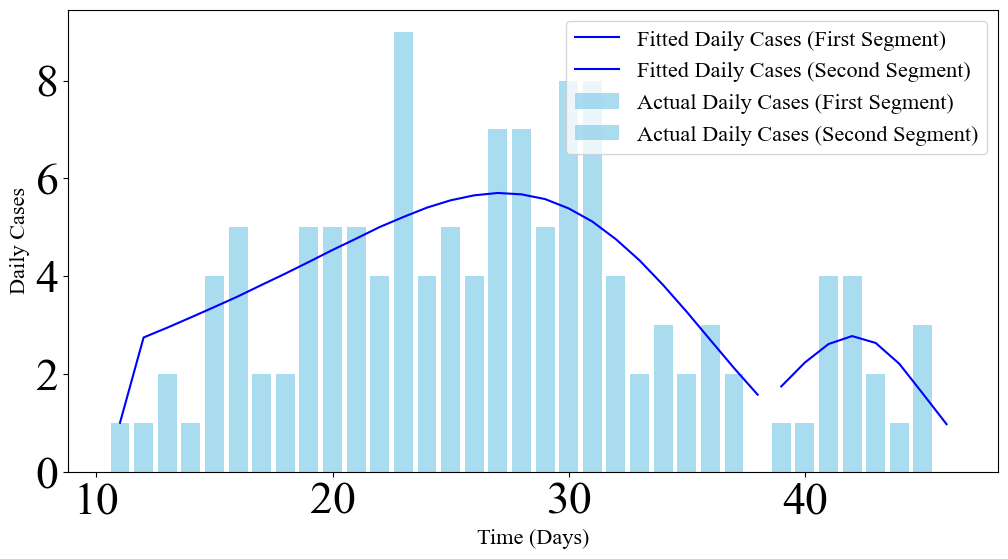

In [230]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters

# 定义 β 的季节性变化函数
def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))

# 定义 MMDM2 模型的微分方程
def MMDM2_model(t, Y, beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3):
    S1, E1, A1, I1, R1, S2, E2, A2, S3, E3, A3, X = Y

    N1 = S1 + E1 + A1 + I1 + R1  # 人口总数
    N2 = S2 + E2 + A2
    N3 = S3 + E3 + A3

    β1 = beta_seasonal(t, beta0, alpha, T)  # 计算季节性β
    β21 = 8 * β1
    β23 = 8 * β1
    β31 = 2 * β1
    β32 = 8 * β1

    # 微分方程
    dS1_dt = br1 * N1 - dr1 * S1 - β1 * S1 * (I1 + κ * A1) / N1 - β21 * S1 * A2 / N1 - β31 * S1 * A3 / N1
    dE1_dt = β1 * S1 * (I1 + κ * A1) / N1 + β21 * S1 * A2 / N1 + β31 * S1 * A3 / N1 - dr1 * E1 - ω1 * E1
    dA1_dt = p * ω1 * E1 - dr1 * A1 - γ_prime * A1
    dI1_dt = (1 - p) * ω1 * E1 - γ * I1 - (dr1 + f) * I1
    dR1_dt = γ_prime * A1 + γ * I1 - dr1 * R1

    dS2_dt = br2 * N2 - dr2 * S2 - β32 * S2 * A3 / N1
    dE2_dt = β32 * S2 * A3 / N1 - ω2 * E2 - dr2 * E2
    dA2_dt = ω2 * E2 - dr2 * A2

    dS3_dt = br3 * N3 - dr3 * S3 - β23 * S3 * A2 / N1
    dE3_dt = β23 * S3 * A2 / N1 - ω3 * E3 - dr3 * E3
    dA3_dt = ω3 * E3 - dr3 * A3

    dX_dt = (1 - p) * ω1 * E1  # 新发病例数

    return [dS1_dt, dE1_dt, dA1_dt, dI1_dt, dR1_dt, dS2_dt, dE2_dt, dA2_dt, dS3_dt, dE3_dt, dA3_dt, dX_dt]

# 提取每日新增病例数据
observed_cases_1 = I_2023[10:38].reset_index(drop=True).values  # 第一段数据
observed_cases_2 = I_2023[38:46].reset_index(drop=True).values  # 第二段数据
t_days_1 = np.arange(11, 39)  # 第一段48-236日
t_days_2 = np.arange(38, 47)  # 第二段拟合236-330日
t_days_3 = np.arange(39, 47)  # 画图用的第二段

# 定义模型包装函数，用于拟合数据
def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 2190999  # 直接代入初始值
    I1_0 = 1        # 直接代入初始值
    E1_0 = 0        # 直接代入初始值
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.00605
    dr1 = 0.0073
    κ = 1
    p = 0.043
    f = 0.031746
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))

# 创建 lmfit 模型
model = Model(model_fit)

# 设置拟合参数及初始值和边界
params = Parameters()
params.add('beta0', value=0.001, min=0, max=1)  # β0 的范围设为 [0.01, 0.5]
params.add('alpha', value=2, min=-10, max=10)       # α 的范围设为 [-10, 10]
params.add('T', value=52, vary=False)               # T 固定为 52 周
params.add('S2_0', value=3000, min=1000, max=1e4)  # S2_0 的范围设为 [1000, 1e6]
params.add('S3_0', value=1000, min=1000, max=1e4)  # S3_0 的范围设为 [1000, 1e6]

# 使用 lmfit 进行拟合
result_1 = model.fit(observed_cases_1, params, t=t_days_1)

# 提取第一段拟合结果的最后状态，作为第二段的初始值
S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value

# 使用 MMDM_model 对第一段的各个仓室值进行求解
initial_state_segment1 = [
    2190999, 0, 0, 1, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.00605
dr1 = 0.0073
κ = 1
p = 0.043
f = 0.031746
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))

# 提取第一段拟合结果的最后一个状态
final_state_segment1 = result_segment1.y[:, -1]

# 第二段数据的拟合
def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.00605
    dr1 = 0.0073
    κ = 1
    p = 0.043
    f = 0.031746
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt

# 创建第二段拟合模型
model_segment2 = Model(model_fit_segment2)

# 设置第二段拟合参数
params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=52)  # 用拟合的T效果比较好
# params_segment2.add('T', value=52, vary=False) 

# 使用 lmfit 进行第二段拟合
result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)

# 输出拟合报告
print(result_1.fit_report())
print(result_2.fit_report())

# 绘制第一段和第二段拟合结果
plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

R_2023 的中位数: 3.417129818737473
R_2023 的中位数: 0.028579708988165087


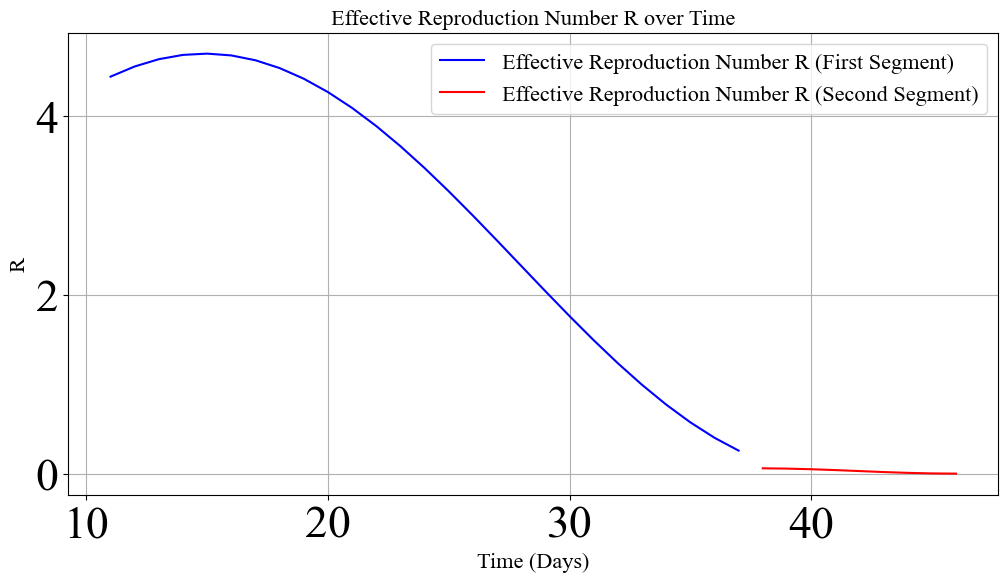

In [231]:
N1 = 2191000


# 定义有效再生数 R 的计算函数
def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    
    # 将大整数转换为浮点数
    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    
    # 计算各项
    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    
    # 计算 R
    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(11, 38)
# 计算 R 随时间的变化（分段）
R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

import statistics

# 如果 R_2023 是列表
median_R_1 = statistics.median(R_values_1)
median_R_2 = statistics.median(R_values_2)
print("R_2023 的中位数:", median_R_1)
print("R_2023 的中位数:", median_R_2)

# 绘制 R 随时间变化的图
plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 连接 result_1.best_fit 和 result_2.best_fit
result_2023 = np.concatenate((result_1.best_fit, result_2.best_fit))

# 提取 I_2023[47:329] 的数据
observed_cases_2023 = I_2023[10:46].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2023# 这里是您给出的数据

# 假设模型的预测数据是：
y_pred = result_2023  

# 计算MSE，均方误差
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# 计算RMSE，均方根误差
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 计算R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# 计算MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# 计算MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')

# 2) Pearson 相关及其 p 值
r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 2.2135271370898795
RMSE: 1.4877927063572665
R-squared: 0.5783757834114516
MAE: 1.2565504771513336
MAPE: inf%


C:\Users\Irene\AppData\Local\Temp\ipykernel_39640\2571978001.py:31: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


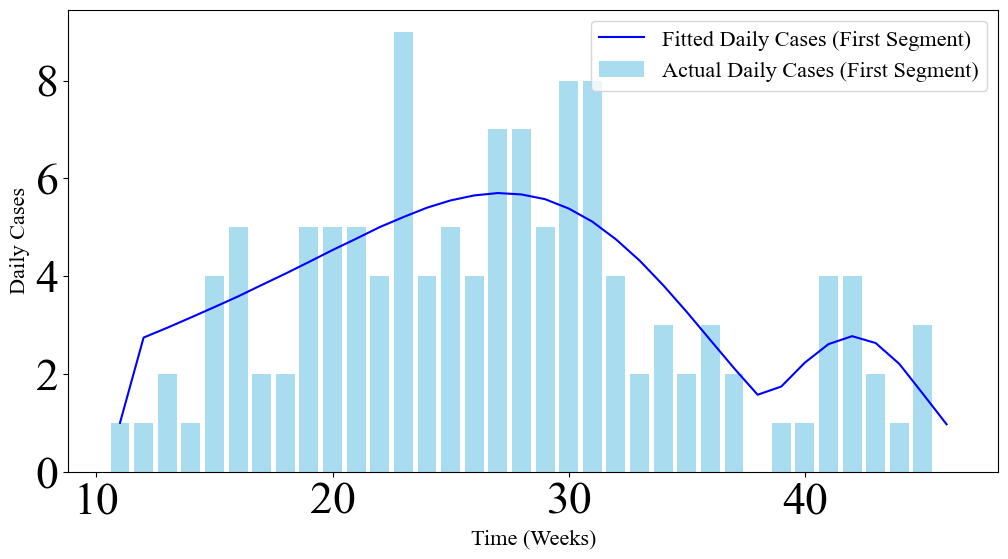

皮尔森相关系数：0.7781499281519595
p值：2.327391930152068e-08


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(11, 47), observed_cases_2023, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(11, 47), result_2023, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)
plt.savefig('../../outcome/Figure/Fit/Manshan/2023.pdf', format='pdf')
plt.show()

# 计算相关系数
from scipy.stats import pearsonr

# 计算皮尔森相关系数和p值
corr, p_value = pearsonr(observed_cases_2023, result_2023)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

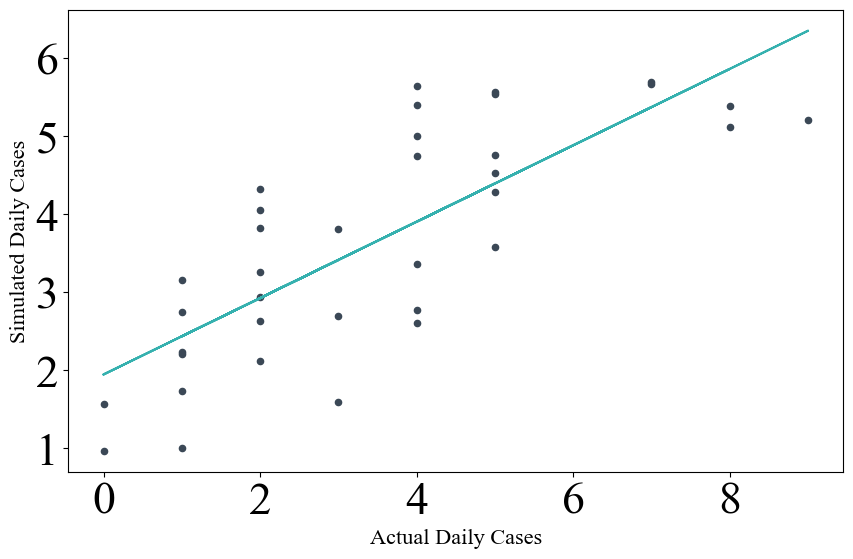

R²：0.6055173106828997


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  # 导入 MaxNLocator

# 确保I_obs和predicted_cases是numpy数组
I_obs = np.array(observed_cases_2023)
predicted_cases = np.array(result_2023)

# 创建线性回归模型
model = LinearRegression()

# 训练模型，需要将I_obs转换为二维数组
model.fit(I_obs.reshape(-1, 1), predicted_cases)

# 预测
y_pred = model.predict(I_obs.reshape(-1, 1))

# 计算R2值
r2 = r2_score(predicted_cases, y_pred)

# 绘制散点图和回归线
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
plt.xlabel('Actual Daily Cases')
plt.ylabel('Simulated Daily Cases')
# plt.legend()
# 设置 y 轴刻度为整数
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../outcome/Figure/Goodness of fit/Manshan/2023.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

R_2023 的中位数: 2.181560853329676
R_2023 的平均数为: 2.259324554841643


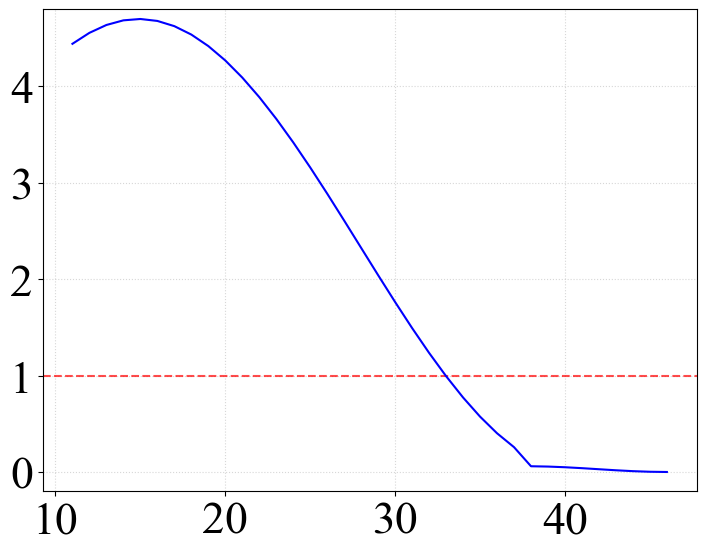

In [ ]:
R_2023 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2023).to_excel('../../outcome/Result/Fit/Manshan/R_2023.xlsx', index=False)

median_R_23 = statistics.median(R_2023)
print("R_2023 的中位数:", median_R_23)
average_R = np.mean(R_2023)
print(f"R_2023 的平均数为: {average_R}")
# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 
# 创建图表
plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')
# 坐标轴设置
plt.ylim(-0.2, 4.8)
plt.yticks(np.arange(0, 4.1, 1))  # 显式设置y轴刻度，步长为1（确保1可见）
plt.grid(True, linestyle=':', alpha=0.5)
# 保存和显示
plt.tight_layout()
plt.plot(np.arange(11, 47), R_2023, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
# plt.legend()
# plt.ylim(-0.2, 4.2)
plt.savefig('../../outcome/Figure/Fit/Manshan/R_2023.pdf', format='pdf')
plt.show()

## 2022

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 117
    # data points      = 20
    # variables        = 4
    chi-square         = 111.033407
    reduced chi-square = 6.93958794
    Akaike info crit   = 42.2819769
    Bayesian info crit = 46.2649060
    R-squared          = 0.41111956
[[Variables]]
    beta0:  0.06676331 +/- 0.07277789 (109.01%) (init = 0.001)
    alpha:  4.21459993 +/- 10.6309620 (252.24%) (init = 2)
    T:      52 (fixed)
    S2_0:   9518.95446 +/- 70255.0129 (738.05%) (init = 3000)
    S3_0:   934.900863 +/- 5.6074e+10 (5997824205.88%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta0, S2_0)  = -0.9511
    C(alpha, S3_0)  = -0.9109
    C(S2_0, S3_0)   = +0.8812
    C(beta0, S3_0)  = -0.7099
    C(alpha, S2_0)  = -0.6247
    C(beta0, alpha) = +0.4090
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 122
    # d

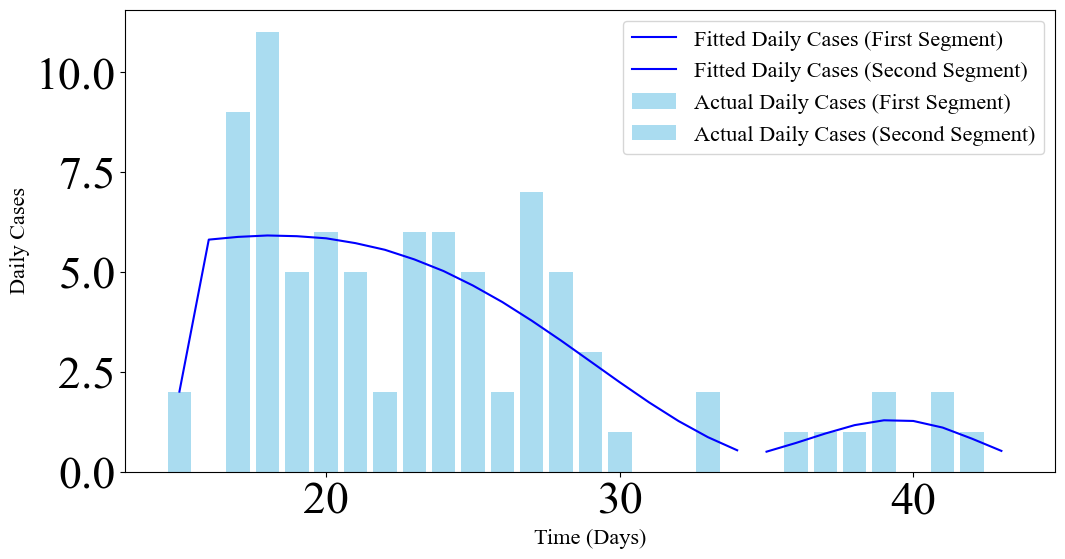

In [239]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters

# 定义 β 的季节性变化函数
def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))

# 定义 MMDM2 模型的微分方程
def MMDM2_model(t, Y, beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3):
    S1, E1, A1, I1, R1, S2, E2, A2, S3, E3, A3, X = Y

    N1 = S1 + E1 + A1 + I1 + R1  # 人口总数
    N2 = S2 + E2 + A2
    N3 = S3 + E3 + A3

    β1 = beta_seasonal(t, beta0, alpha, T)  # 计算季节性β
    β21 = 8 * β1
    β23 = 8 * β1
    β31 = 2 * β1
    β32 = 8 * β1

    # 微分方程
    dS1_dt = br1 * N1 - dr1 * S1 - β1 * S1 * (I1 + κ * A1) / N1 - β21 * S1 * A2 / N1 - β31 * S1 * A3 / N1
    dE1_dt = β1 * S1 * (I1 + κ * A1) / N1 + β21 * S1 * A2 / N1 + β31 * S1 * A3 / N1 - dr1 * E1 - ω1 * E1
    dA1_dt = p * ω1 * E1 - dr1 * A1 - γ_prime * A1
    dI1_dt = (1 - p) * ω1 * E1 - γ * I1 - (dr1 + f) * I1
    dR1_dt = γ_prime * A1 + γ * I1 - dr1 * R1

    dS2_dt = br2 * N2 - dr2 * S2 - β32 * S2 * A3 / N1
    dE2_dt = β32 * S2 * A3 / N1 - ω2 * E2 - dr2 * E2
    dA2_dt = ω2 * E2 - dr2 * A2

    dS3_dt = br3 * N3 - dr3 * S3 - β23 * S3 * A2 / N1
    dE3_dt = β23 * S3 * A2 / N1 - ω3 * E3 - dr3 * E3
    dA3_dt = ω3 * E3 - dr3 * A3

    dX_dt = (1 - p) * ω1 * E1  # 新发病例数

    return [dS1_dt, dE1_dt, dA1_dt, dI1_dt, dR1_dt, dS2_dt, dE2_dt, dA2_dt, dS3_dt, dE3_dt, dA3_dt, dX_dt]

# 提取每日新增病例数据
observed_cases_1 = I_2022[14:34].reset_index(drop=True).values  # 第一段数据
observed_cases_2 = I_2022[34:43].reset_index(drop=True).values  # 第二段数据
t_days_1 = np.arange(15, 35)  # 第一段48-236日
t_days_2 = np.arange(34, 44)  # 第二段拟合236-330日
t_days_3 = np.arange(35, 44)  # 画图用的第二段

# 定义模型包装函数，用于拟合数据
def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 2185998  # 直接代入初始值
    I1_0 = 2        # 直接代入初始值
    E1_0 = 0        # 直接代入初始值
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.00684
    dr1 = 0.0069
    κ = 1
    p = 0.043
    f = 0.047059
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))

# 创建 lmfit 模型
model = Model(model_fit)

# 设置拟合参数及初始值和边界
params = Parameters()
params.add('beta0', value=0.001, min=0, max=1)  # β0 的范围设为 [0.01, 0.5]
params.add('alpha', value=2, min=-10, max=10)       # α 的范围设为 [-10, 10]
params.add('T', value=52, vary=False)               # T 固定为 52 周
params.add('S2_0', value=3000, min=1000, max=1e4)  # S2_0 的范围设为 [1000, 1e6]
params.add('S3_0', value=1000, min=100, max=1e3)  # S3_0 的范围设为 [1000, 1e6]

# 使用 lmfit 进行拟合
result_1 = model.fit(observed_cases_1, params, t=t_days_1)

# 提取第一段拟合结果的最后状态，作为第二段的初始值
S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value

# 使用 MMDM_model 对第一段的各个仓室值进行求解
initial_state_segment1 = [
    2185998, 0, 0, 2, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.00684
dr1 = 0.0069
κ = 1
p = 0.043
f = 0.047059
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))

# 提取第一段拟合结果的最后一个状态
final_state_segment1 = result_segment1.y[:, -1]

# 第二段数据的拟合
def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.00684
    dr1 = 0.0069
    κ = 1
    p = 0.043
    f = 0.047059
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt

# 创建第二段拟合模型
model_segment2 = Model(model_fit_segment2)

# 设置第二段拟合参数
params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=11, min=1, max=52)  # 用拟合的T效果比较好
# params_segment2.add('T', value=52, vary=False) 

# 使用 lmfit 进行第二段拟合
result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)

# 输出拟合报告
print(result_1.fit_report())
print(result_2.fit_report())

# 绘制第一段和第二段拟合结果
plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

R_2022 的中位数: 1.7836351244800819
R_2022 的中位数: 0.03422944379554328


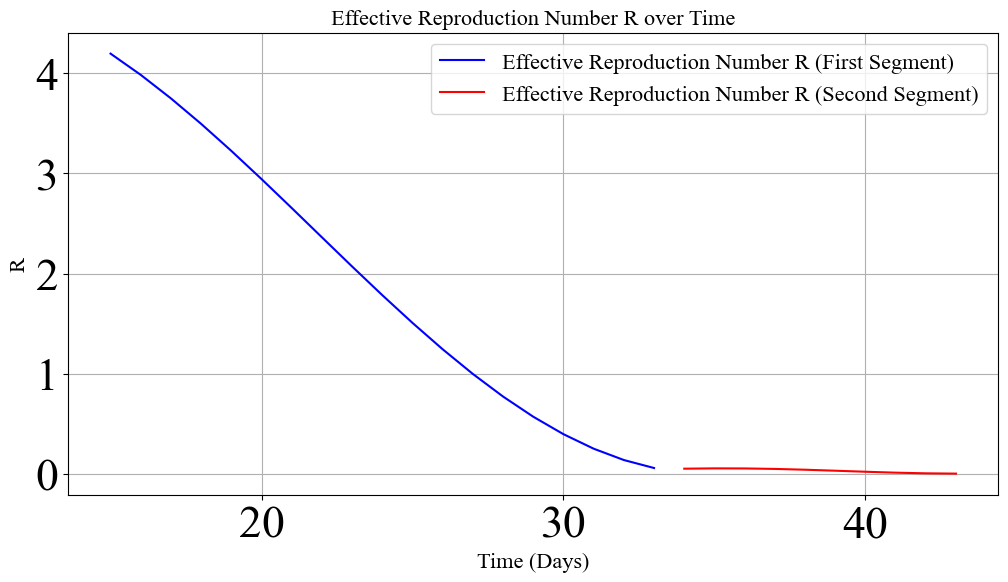

In [240]:
N1 = 2186000


# 定义有效再生数 R 的计算函数
def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    
    # 将大整数转换为浮点数
    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    
    # 计算各项
    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    
    # 计算 R
    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(15, 34)
# 计算 R 随时间的变化（分段）
R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

import statistics

# 如果 R_2022 是列表
median_R_1 = statistics.median(R_values_1)
median_R_2 = statistics.median(R_values_2)
print("R_2022 的中位数:", median_R_1)
print("R_2022 的中位数:", median_R_2)

# 绘制 R 随时间变化的图
plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 连接 result_1.best_fit 和 result_2.best_fit
result_2022 = np.concatenate((result_1.best_fit, result_2.best_fit))

# 提取 I_2022[47:329] 的数据
observed_cases_2022 = I_2022[14:43].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2022# 这里是您给出的数据

# 假设模型的预测数据是：
y_pred = result_2022  

# 计算MSE，均方误差
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# 计算RMSE，均方根误差
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 计算R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# 计算MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# 计算MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')

# 2) Pearson 相关及其 p 值
r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 3.9523383508258374
RMSE: 1.988048880391485
R-squared: 0.5375742135441667
MAE: 1.354186362199934
MAPE: inf%


C:\Users\Irene\AppData\Local\Temp\ipykernel_39640\2521891859.py:31: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


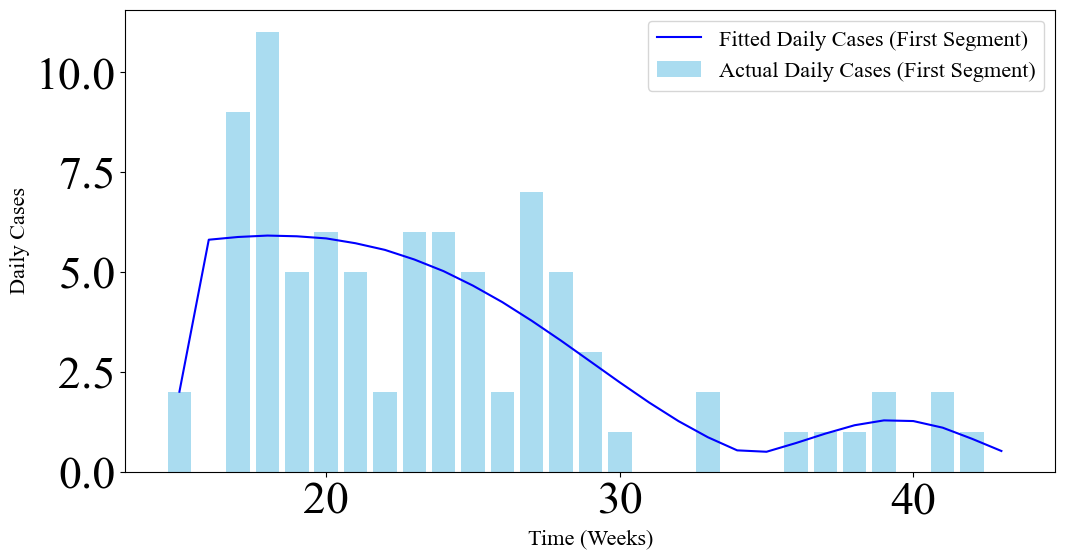

皮尔森相关系数：0.7337566375960172
p值：5.9187574828644375e-06


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(15, 44), observed_cases_2022, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(15, 44), result_2022, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)
plt.savefig('../../outcome/Figure/Fit/Manshan/2022.pdf', format='pdf')
plt.show()

# 计算相关系数
from scipy.stats import pearsonr

# 计算皮尔森相关系数和p值
corr, p_value = pearsonr(observed_cases_2022, result_2022)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

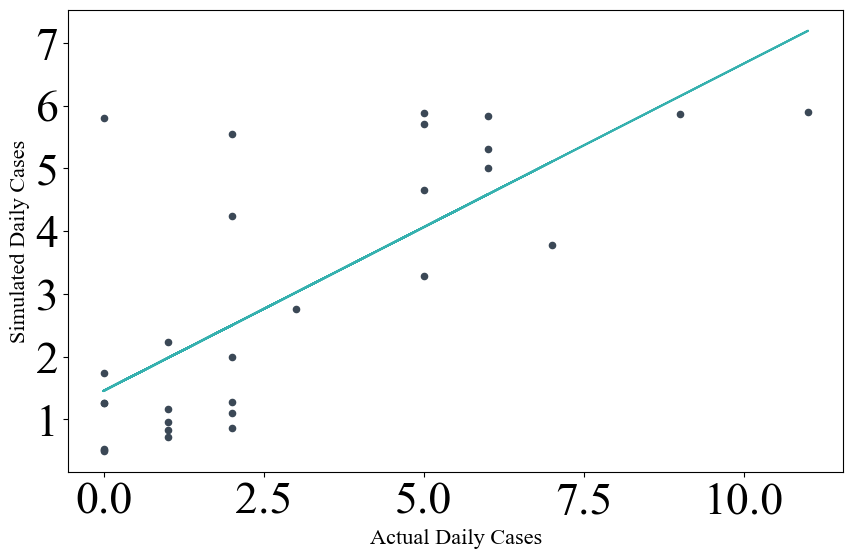

R²：0.5383988032162131


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  # 导入 MaxNLocator

# 确保I_obs和predicted_cases是numpy数组
I_obs = np.array(observed_cases_2022)
predicted_cases = np.array(result_2022)

# 创建线性回归模型
model = LinearRegression()

# 训练模型，需要将I_obs转换为二维数组
model.fit(I_obs.reshape(-1, 1), predicted_cases)

# 预测
y_pred = model.predict(I_obs.reshape(-1, 1))

# 计算R2值
r2 = r2_score(predicted_cases, y_pred)

# 绘制散点图和回归线
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
plt.xlabel('Actual Daily Cases')
plt.ylabel('Simulated Daily Cases')
# plt.legend()
# 设置 y 轴刻度为整数
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../outcome/Figure/Goodness of fit/Manshan/2022.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

Rt_11 的中位数为: 0.5687235550503068
R_2023 的平均数为: 1.2651373870856615


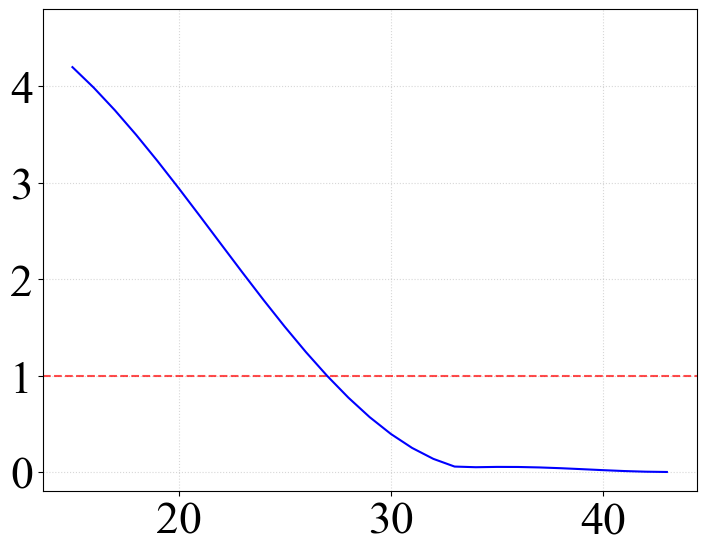

In [244]:
R_2022 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2022).to_excel('../../结果图/拟合结果2/R_2022.xlsx', index=False)

import statistics
# 计算Rt_11_values的中位数
median_Rt_11 = statistics.median(R_2022)
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2022)
print(f"R_2023 的平均数为: {average_R}")
# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 
# 创建图表
plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')
# 坐标轴设置
plt.ylim(-0.2, 4.8)
plt.yticks(np.arange(0, 4.1, 1))  # 显式设置y轴刻度，步长为1（确保1可见）
plt.grid(True, linestyle=':', alpha=0.5)
# 保存和显示
plt.tight_layout()
plt.plot(np.arange(15, 44), R_2022, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
# plt.legend()
# plt.ylim(-0.2, 4.2)
plt.savefig('../../结果图/拟合结果2/R_2022.pdf', format='pdf')
plt.show()

## 2021

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 74
    # data points      = 21
    # variables        = 4
    chi-square         = 52.1144417
    reduced chi-square = 3.06555539
    Akaike info crit   = 27.0873129
    Bayesian info crit = 31.2654027
    R-squared          = 0.08033338
[[Variables]]
    beta0:  0.03351801 +/- 0.08840485 (263.75%) (init = 0.001)
    alpha: -1.06995815 +/- 48.6308859 (4545.12%) (init = 2)
    T:      52 (fixed)
    S2_0:   4014.67332 +/- 96255.7730 (2397.60%) (init = 3000)
    S3_0:   8287.91375 +/- 3.1454e+12 (37951286937.59%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta0, alpha) = -0.9846
    C(alpha, S3_0)  = +0.9569
    C(S2_0, S3_0)   = -0.9466
    C(beta0, S3_0)  = -0.9353
    C(alpha, S2_0)  = -0.8153
    C(beta0, S2_0)  = +0.7758
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 148
    #

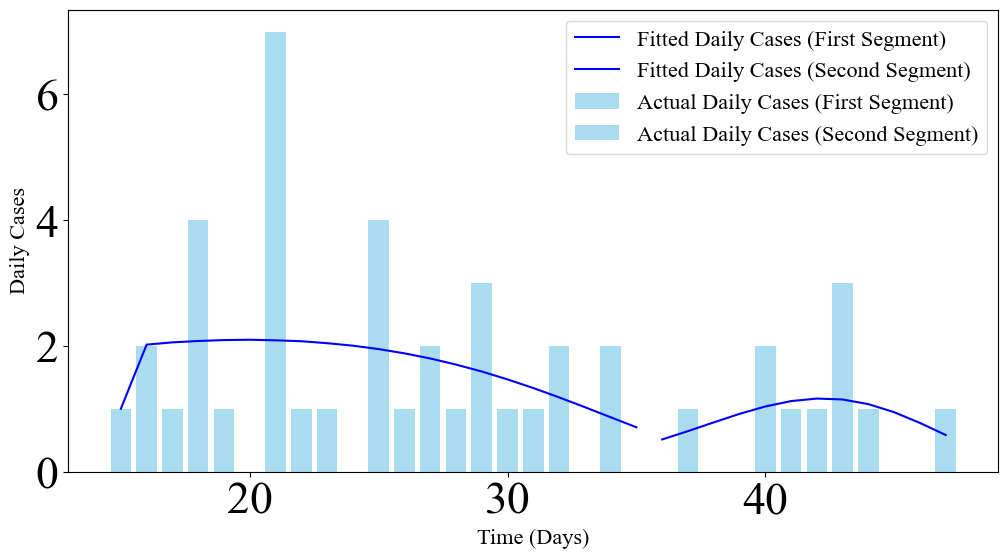

In [248]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters

# 定义 β 的季节性变化函数
def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))

# 定义 MMDM2 模型的微分方程
def MMDM2_model(t, Y, beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3):
    S1, E1, A1, I1, R1, S2, E2, A2, S3, E3, A3, X = Y

    N1 = S1 + E1 + A1 + I1 + R1  # 人口总数
    N2 = S2 + E2 + A2
    N3 = S3 + E3 + A3

    β1 = beta_seasonal(t, beta0, alpha, T)  # 计算季节性β
    β21 = 8 * β1
    β23 = 8 * β1
    β31 = 2 * β1
    β32 = 8 * β1

    # 微分方程
    dS1_dt = br1 * N1 - dr1 * S1 - β1 * S1 * (I1 + κ * A1) / N1 - β21 * S1 * A2 / N1 - β31 * S1 * A3 / N1
    dE1_dt = β1 * S1 * (I1 + κ * A1) / N1 + β21 * S1 * A2 / N1 + β31 * S1 * A3 / N1 - dr1 * E1 - ω1 * E1
    dA1_dt = p * ω1 * E1 - dr1 * A1 - γ_prime * A1
    dI1_dt = (1 - p) * ω1 * E1 - γ * I1 - (dr1 + f) * I1
    dR1_dt = γ_prime * A1 + γ * I1 - dr1 * R1

    dS2_dt = br2 * N2 - dr2 * S2 - β32 * S2 * A3 / N1
    dE2_dt = β32 * S2 * A3 / N1 - ω2 * E2 - dr2 * E2
    dA2_dt = ω2 * E2 - dr2 * A2

    dS3_dt = br3 * N3 - dr3 * S3 - β23 * S3 * A2 / N1
    dE3_dt = β23 * S3 * A2 / N1 - ω3 * E3 - dr3 * E3
    dA3_dt = ω3 * E3 - dr3 * A3

    dX_dt = (1 - p) * ω1 * E1  # 新发病例数

    return [dS1_dt, dE1_dt, dA1_dt, dI1_dt, dR1_dt, dS2_dt, dE2_dt, dA2_dt, dS3_dt, dE3_dt, dA3_dt, dX_dt]

# 提取每日新增病例数据
observed_cases_1 = I_2021[14:35].reset_index(drop=True).values  # 第一段数据
observed_cases_2 = I_2021[35:47].reset_index(drop=True).values  # 第二段数据
t_days_1 = np.arange(15, 36)  # 第一段48-236日
t_days_2 = np.arange(35, 48)  # 第二段拟合236-330日
t_days_3 = np.arange(36, 48)  # 画图用的第二段

# 定义模型包装函数，用于拟合数据
def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 2156999  # 直接代入初始值
    I1_0 = 1        # 直接代入初始值
    E1_0 = 0        # 直接代入初始值
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.00769
    dr1 = 0.00647
    κ = 1
    p = 0.043
    f = 0.155556
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))

# 创建 lmfit 模型
model = Model(model_fit)

# 设置拟合参数及初始值和边界
params = Parameters()
params.add('beta0', value=0.001, min=0, max=1)  # β0 的范围设为 [0.01, 0.5]
params.add('alpha', value=2, min=-10, max=10)       # α 的范围设为 [-10, 10]
params.add('T', value=52, vary=False)               # T 固定为 52 周
params.add('S2_0', value=3000, min=1000, max=1e4)  # S2_0 的范围设为 [1000, 1e6]
params.add('S3_0', value=1000, min=1000, max=1e4)  # S3_0 的范围设为 [1000, 1e6]


# 使用 lmfit 进行拟合
result_1 = model.fit(observed_cases_1, params, t=t_days_1)

# 提取第一段拟合结果的最后状态，作为第二段的初始值
S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value

# 使用 MMDM_model 对第一段的各个仓室值进行求解
initial_state_segment1 = [
    2156999, 0, 0, 1, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.00769
dr1 = 0.00647
κ = 1
p = 0.043
f = 0.155556
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))

# 提取第一段拟合结果的最后一个状态
final_state_segment1 = result_segment1.y[:, -1]

# 第二段数据的拟合
def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.00769
    dr1 = 0.00647
    κ = 1
    p = 0.043
    f = 0.155556
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt

# 创建第二段拟合模型
model_segment2 = Model(model_fit_segment2)

# 设置第二段拟合参数
params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=52)  # 用拟合的T效果比较好
# params_segment2.add('T', value=52, vary=False) 

# 使用 lmfit 进行第二段拟合
result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)

# 输出拟合报告
print(result_1.fit_report())
print(result_2.fit_report())

# 绘制第一段和第二段拟合结果
plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

R_2021 的中位数: 3.1130973282613157
R_2021 的中位数: 0.06909779483242047


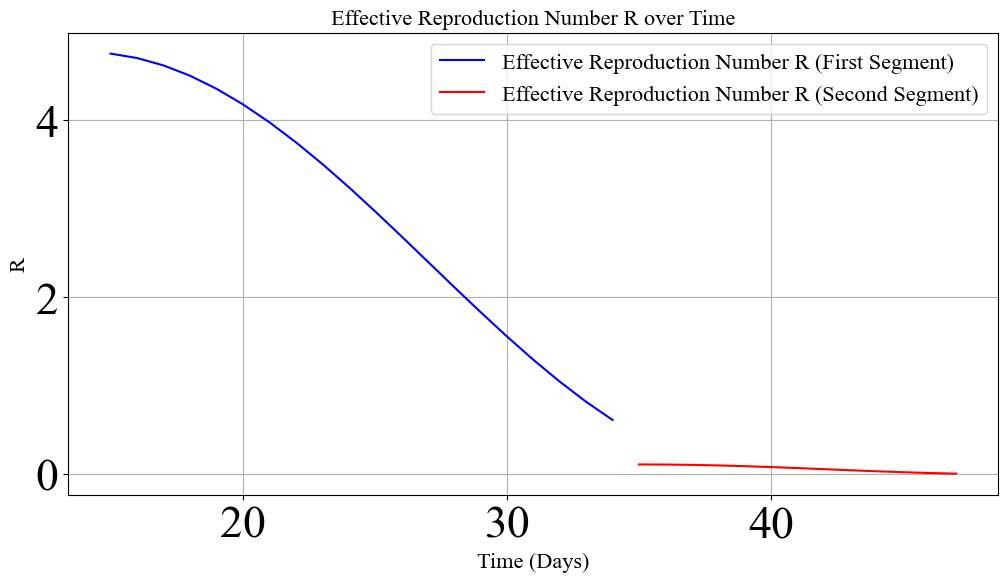

In [249]:
N1 = 2157000


# 定义有效再生数 R 的计算函数
def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    
    # 将大整数转换为浮点数
    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    
    # 计算各项
    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    
    # 计算 R
    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(15, 35)
# 计算 R 随时间的变化（分段）
R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

import statistics

# 如果 R_2023 是列表
median_R_1 = statistics.median(R_values_1)
median_R_2 = statistics.median(R_values_2)
print("R_2021 的中位数:", median_R_1)
print("R_2021 的中位数:", median_R_2)

# 绘制 R 随时间变化的图
plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 连接 result_1.best_fit 和 result_2.best_fit
result_2021 = np.concatenate((result_1.best_fit, result_2.best_fit))

# 提取 I_2023[47:329] 的数据
observed_cases_2021 = I_2021[14:47].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2021# 这里是您给出的数据

# 假设模型的预测数据是：
y_pred = result_2021  

# 计算MSE，均方误差
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# 计算RMSE，均方根误差
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 计算R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# 计算MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# 计算MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')

# 2) Pearson 相关及其 p 值
r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 1.8192130369831836
RMSE: 1.348782056888059
R-squared: 0.16196150707500556
MAE: 0.9947757571009956
MAPE: inf%


C:\Users\Irene\AppData\Local\Temp\ipykernel_39640\1976818660.py:31: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


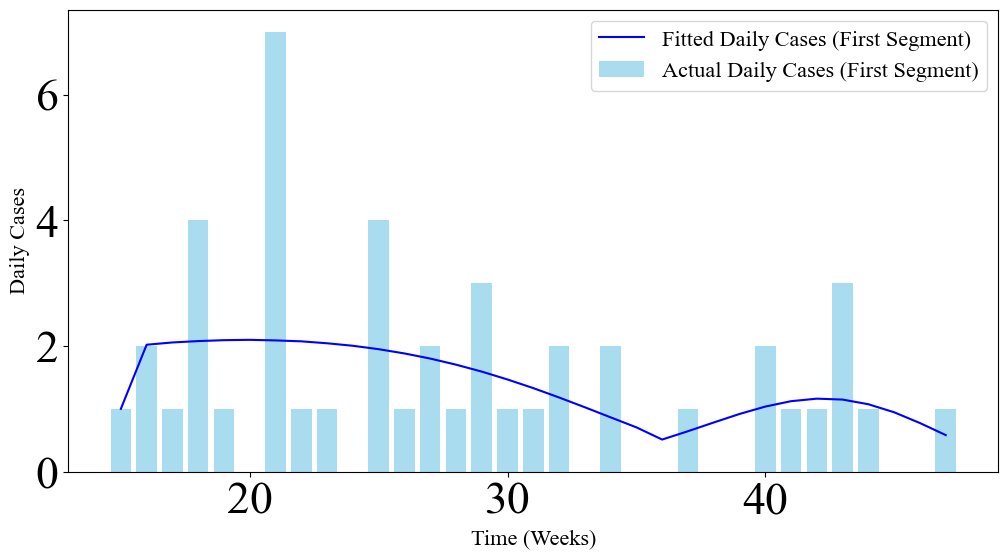

皮尔森相关系数：0.4046529407680196
p值：0.019500251962708263


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(15, 48), observed_cases_2021, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(15, 48), result_2021, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)
plt.savefig('../../outcome/Figure/Fit/Manshan/2021.pdf', format='pdf')
plt.show()

# 计算相关系数
from scipy.stats import pearsonr

# 计算皮尔森相关系数和p值
corr, p_value = pearsonr(observed_cases_2021, result_2021)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

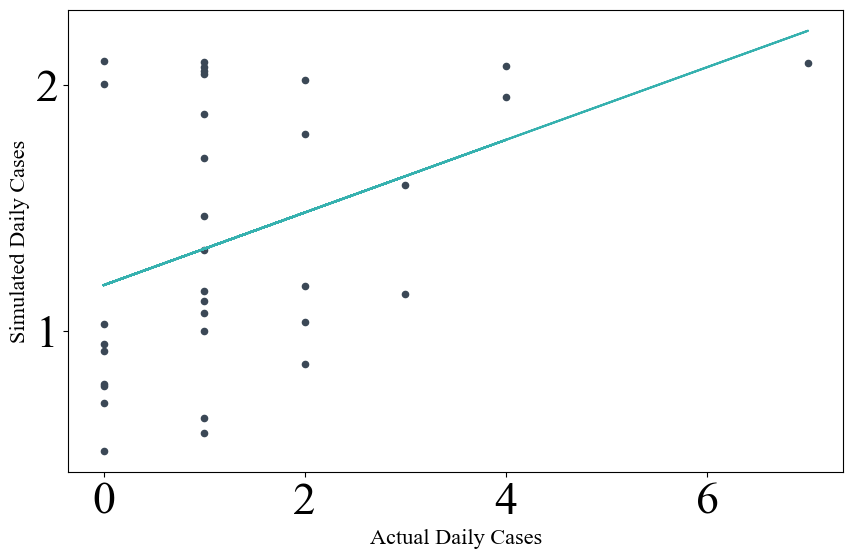

R²：0.16374400247220633


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  # 导入 MaxNLocator

# 确保I_obs和predicted_cases是numpy数组
I_obs = np.array(observed_cases_2021)
predicted_cases = np.array(result_2021)

# 创建线性回归模型
model = LinearRegression()

# 训练模型，需要将I_obs转换为二维数组
model.fit(I_obs.reshape(-1, 1), predicted_cases)

# 预测
y_pred = model.predict(I_obs.reshape(-1, 1))

# 计算R2值
r2 = r2_score(predicted_cases, y_pred)

# 绘制散点图和回归线
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
plt.xlabel('Actual Daily Cases')
plt.ylabel('Simulated Daily Cases')
# plt.legend()
# 设置 y 轴刻度为整数
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../outcome/Figure/Goodness of fit/Manshan/2021.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

Rt_11 的中位数为: 1.2948004370371826
R_2023 的平均数为: 1.8132945775559328


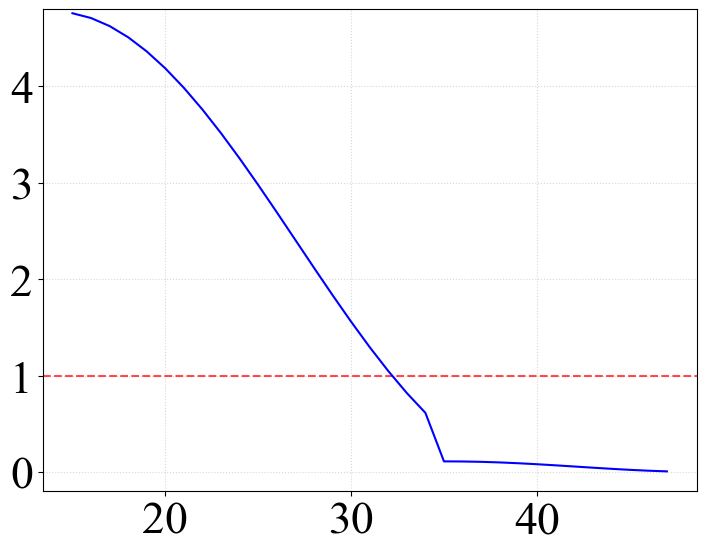

In [ ]:
R_2021 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2021).to_excel('../../outcome/Result/Fit/Manshan/R_2021.xlsx', index=False)

import statistics
# 计算Rt_11_values的中位数
median_Rt_11 = statistics.median(R_2021)
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2021)
print(f"R_2023 的平均数为: {average_R}")
# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 
# 创建图表
plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')
# 坐标轴设置
plt.ylim(-0.2, 4.8)
plt.yticks(np.arange(0, 4.1, 1))  # 显式设置y轴刻度，步长为1（确保1可见）
plt.grid(True, linestyle=':', alpha=0.5)
# 保存和显示
plt.tight_layout()
plt.plot(np.arange(15, 48), R_2021, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
# plt.legend()
# plt.ylim(-0.2, 4.2)
plt.savefig('../../outcome/Figure/Fit/Manshan/R_2021.pdf', format='pdf')
plt.show()

## 2020

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 92
    # data points      = 27
    # variables        = 4
    chi-square         = 63.1832325
    reduced chi-square = 2.74709707
    Akaike info crit   = 30.9554565
    Bayesian info crit = 36.1388040
    R-squared          = 0.18140726
[[Variables]]
    beta0:  0.04294792 +/- 0.06183256 (143.97%) (init = 0.001)
    alpha: -3.19631986 +/- 16.8718932 (527.85%) (init = 2)
    T:      52 (fixed)
    S2_0:   1003.58746 +/- 23704.9428 (2362.02%) (init = 3000)
    S3_0:   3004.18879 +/- 9.9552e+11 (33137644932.83%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta0, S3_0)  = -0.8844
    C(S2_0, S3_0)   = -0.8687
    C(beta0, alpha) = -0.5953
    C(beta0, S2_0)  = +0.5445
    C(alpha, S2_0)  = +0.3127
    C(alpha, S3_0)  = +0.1915


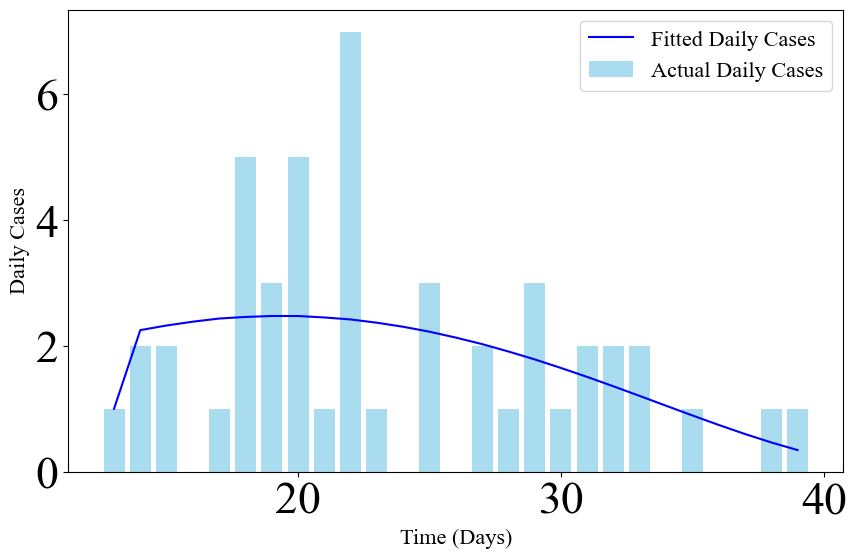

In [256]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters

# 定义 β 的季节性变化函数
def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))

# 定义 MMDM2 模型的微分方程
def MMDM2_model(t, Y, beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3):
    S1, E1, A1, I1, R1, S2, E2, A2, S3, E3, A3, X = Y

    N1 = S1 + E1 + A1 + I1 + R1  # 人口总数
    N2 = S2 + E2 + A2
    N3 = S3 + E3 + A3

    β1 = beta_seasonal(t, beta0, alpha, T)  # 计算季节性β
    β21 = 8 * β1
    β23 = 8 * β1
    β31 = 2 * β1
    β32 = 8 * β1

    # 微分方程
    dS1_dt = br1 * N1 - dr1 * S1 - β1 * S1 * (I1 + κ * A1) / N1 - β21 * S1 * A2 / N1 - β31 * S1 * A3 / N1
    dE1_dt = β1 * S1 * (I1 + κ * A1) / N1 + β21 * S1 * A2 / N1 + β31 * S1 * A3 / N1 - dr1 * E1 - ω1 * E1
    dA1_dt = p * ω1 * E1 - dr1 * A1 - γ_prime * A1
    dI1_dt = (1 - p) * ω1 * E1 - γ * I1 - (dr1 + f) * I1
    dR1_dt = γ_prime * A1 + γ * I1 - dr1 * R1

    dS2_dt = br2 * N2 - dr2 * S2 - β32 * S2 * A3 / N1
    dE2_dt = β32 * S2 * A3 / N1 - ω2 * E2 - dr2 * E2
    dA2_dt = ω2 * E2 - dr2 * A2

    dS3_dt = br3 * N3 - dr3 * S3 - β23 * S3 * A2 / N1
    dE3_dt = β23 * S3 * A2 / N1 - ω3 * E3 - dr3 * E3
    dA3_dt = ω3 * E3 - dr3 * A3

    dX_dt = (1 - p) * ω1 * E1  # 新发病例数

    return [dS1_dt, dE1_dt, dA1_dt, dI1_dt, dR1_dt, dS2_dt, dE2_dt, dA2_dt, dS3_dt, dE3_dt, dA3_dt, dX_dt]

# 提取每日新增病例数据
observed_cases = I_2020[12:39].reset_index(drop=True).values
t_days = np.arange(13, 40)

# 定义模型包装函数，用于拟合数据
def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 2160699  # 直接代入初始值
    I1_0 = 1        # 直接代入初始值
    E1_0 = 0        # 直接代入初始值
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.01138
    dr1 = 0.00598
    κ = 1
    p = 0.043
    f = 0.23404
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases[0]], dX_dt))

# 创建 lmfit 模型
model = Model(model_fit)

# 设置拟合参数及初始值和边界
params = Parameters()
params.add('beta0', value=0.001, min=0, max=1)  # β0 的范围设为 [0.01, 0.5]
params.add('alpha', value=2, min=-10, max=10)       # α 的范围设为 [-10, 10]
params.add('T', value=52, vary=False)               # T 固定为 52 周
params.add('S2_0', value=3000, min=1000, max=1e4)  # S2_0 的范围设为 [1000, 1e6]
params.add('S3_0', value=1000, min=1000, max=1e4)  # S3_0 的范围设为 [1000, 1e6]

# params.add('beta0', value=0.05, min=0.01, max=0.2)  # β0 的范围设为 [0.01, 0.5]
# params.add('alpha', value=39, min=-20, max=50)       # α 的范围设为 [-10, 10]
# params.add('T', value=88, min=0, max=521)               # T 固定为 52 周
# params.add('S2_0', value=12000, min=1000, max=1e6)  # S2_0 的范围设为 [1000, 1e6]
# params.add('S3_0', value=12000, min=1000, max=1e6)  # S3_0 的范围设为 [1000, 1e6]

# 使用 lmfit 进行拟合
result_1 = model.fit(observed_cases, params, t=t_days)

# 输出拟合报告
print(result_1.fit_report())

# 绘制拟合结果
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(10,6))
plt.bar(t_days, observed_cases, color='skyblue', label='Actual Daily Cases', alpha=0.7)
plt.plot(t_days, result_1.best_fit, 'b-', label='Fitted Daily Cases')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
# plt.ylim(-1, 31)  # 设置纵坐标范围，包括负数范围和从0标点
plt.legend()
# plt.savefig('../结果图/拟合结果/2023.png', dpi=600, format='png')
# plt.savefig('../结果图/拟合结果/2023.pdf', format='pdf')
plt.show()


# # 计算相关系数
# from scipy.stats import pearsonr

# # 计算皮尔森相关系数和p值
# corr, p_value = pearsonr(I_2023, result.best_fit)

# print(f"皮尔森相关系数：{corr}")
# print(f"p值：{p_value}")



R_2020 的中位数: 1.2645248995264005


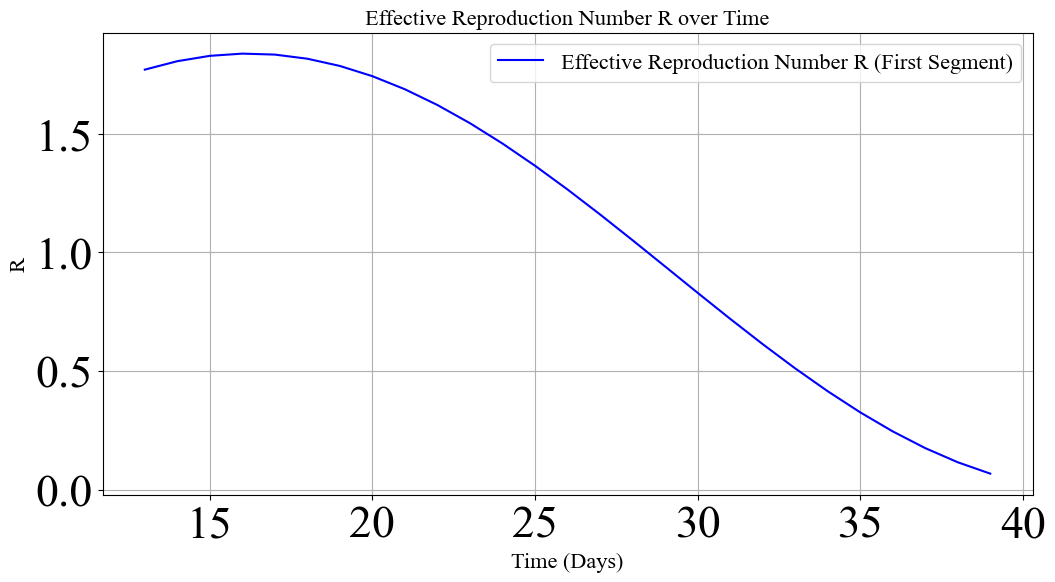

In [257]:
N1 = 2160700


# 定义有效再生数 R 的计算函数
def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    
    # 将大整数转换为浮点数
    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    
    # 计算各项
    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    
    # 计算 R
    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(13, 40)
# 计算 R 随时间的变化（分段）
R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
# R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

import statistics

# 如果 R_2023 是列表
median_R_1 = statistics.median(R_values_1)
# median_R_2 = statistics.median(R_values_2)
print("R_2020 的中位数:", median_R_1)
# print("R_2020 的中位数:", median_R_2)

# 绘制 R 随时间变化的图
plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
# plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 连接 result_1.best_fit 和 result_2.best_fit
result_2020 = result_1.best_fit

# 提取 I_2023[47:329] 的数据
observed_cases_2020 = I_2020[12:39].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2020# 这里是您给出的数据

# 假设模型的预测数据是：
y_pred = result_2020  

# 计算MSE，均方误差
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# 计算RMSE，均方根误差
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 计算R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# 计算MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# 计算MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')

# 2) Pearson 相关及其 p 值
r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 2.340119723991126
RMSE: 1.529744986588002
R-squared: 0.1814072558591504
MAE: 1.1489693720199756
MAPE: inf%


C:\Users\Irene\AppData\Local\Temp\ipykernel_39640\667703138.py:31: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


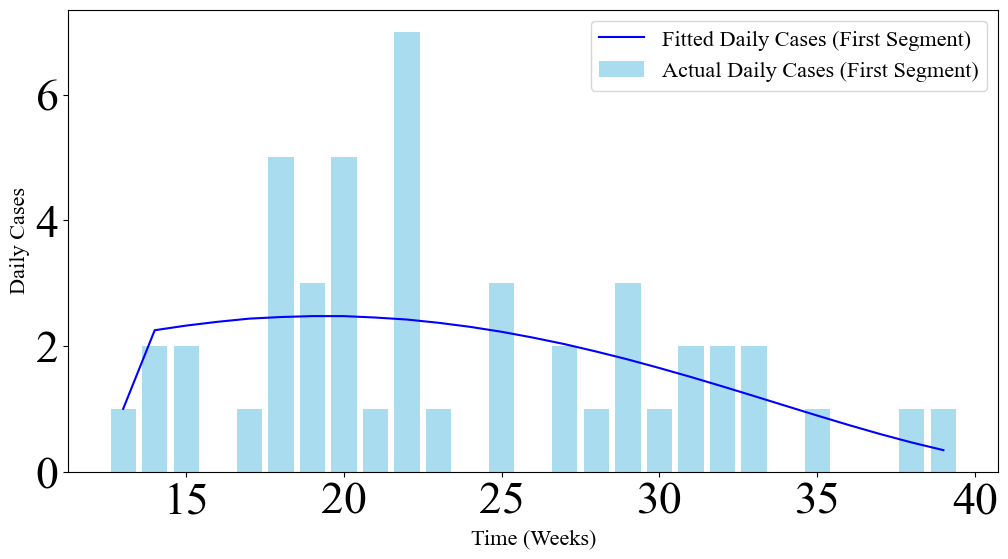

皮尔森相关系数：0.4260550199323655
p值：0.02669729305678805


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(13, 40), observed_cases_2020, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(13, 40), result_2020, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)
plt.savefig('../../outcome/Figure/Fit/Manshan/2020.pdf', format='pdf')
plt.show()

# 计算相关系数
from scipy.stats import pearsonr

# 计算皮尔森相关系数和p值
corr, p_value = pearsonr(observed_cases_2020, result_2020)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

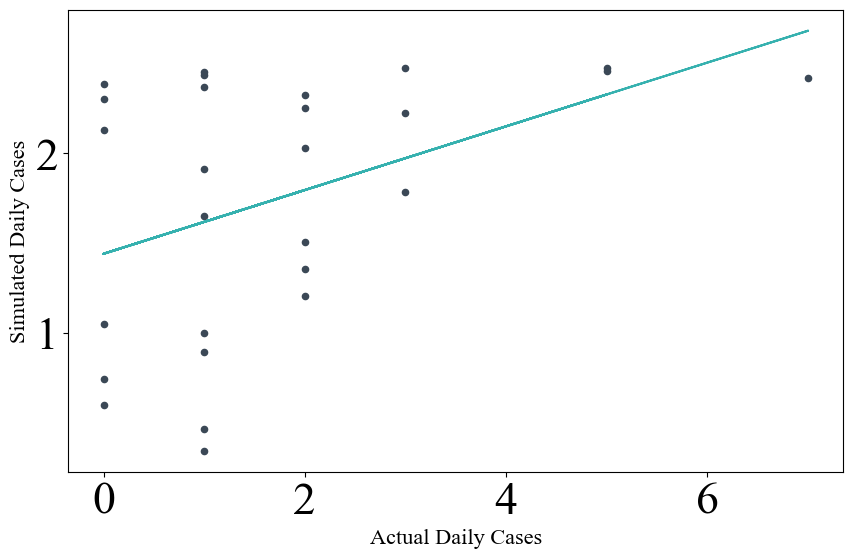

R²：0.1815228800095685


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  # 导入 MaxNLocator

# 确保I_obs和predicted_cases是numpy数组
I_obs = np.array(observed_cases_2020)
predicted_cases = np.array(result_2020)

# 创建线性回归模型
model = LinearRegression()

# 训练模型，需要将I_obs转换为二维数组
model.fit(I_obs.reshape(-1, 1), predicted_cases)

# 预测
y_pred = model.predict(I_obs.reshape(-1, 1))

# 计算R2值
r2 = r2_score(predicted_cases, y_pred)

# 绘制散点图和回归线
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
plt.xlabel('Actual Daily Cases')
plt.ylabel('Simulated Daily Cases')
# plt.legend()
# 设置 y 轴刻度为整数
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../outcome/Figure/Goodness of fit/Manshan/2020.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

Rt_11 的中位数为: 1.2645248995264005
R_2023 的平均数为: 1.1303811056869024


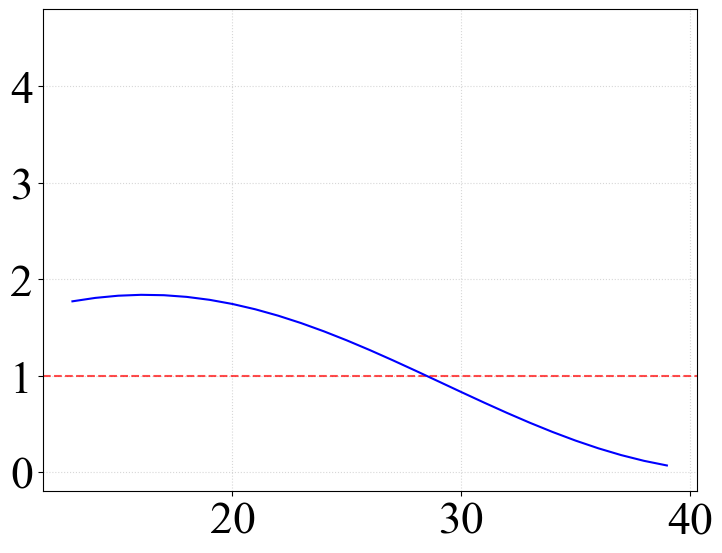

In [ ]:
R_2020 = R_values_1
pd.DataFrame(R_2020).to_excel('../../outcome/Result/Fit/Manshan/R_2020.xlsx', index=False)

import statistics
# 计算Rt_11_values的中位数
median_Rt_11 = statistics.median(R_2020)
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2020)
print(f"R_2023 的平均数为: {average_R}")
# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 
# 创建图表
plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')
# 坐标轴设置
plt.ylim(-0.2, 4.8)
plt.yticks(np.arange(0, 4.1, 1))  # 显式设置y轴刻度，步长为1（确保1可见）
plt.grid(True, linestyle=':', alpha=0.5)
# 保存和显示
plt.tight_layout()
plt.plot(np.arange(13, 40), R_2020, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
# plt.legend()
# # plt.ylim(-0.2, 4.2)
plt.savefig('../../outcome/Figure/Fit/Manshan/R_2020.pdf', format='pdf')
plt.show()

## 2019

R_2019 的中位数: 0.34080091079228897


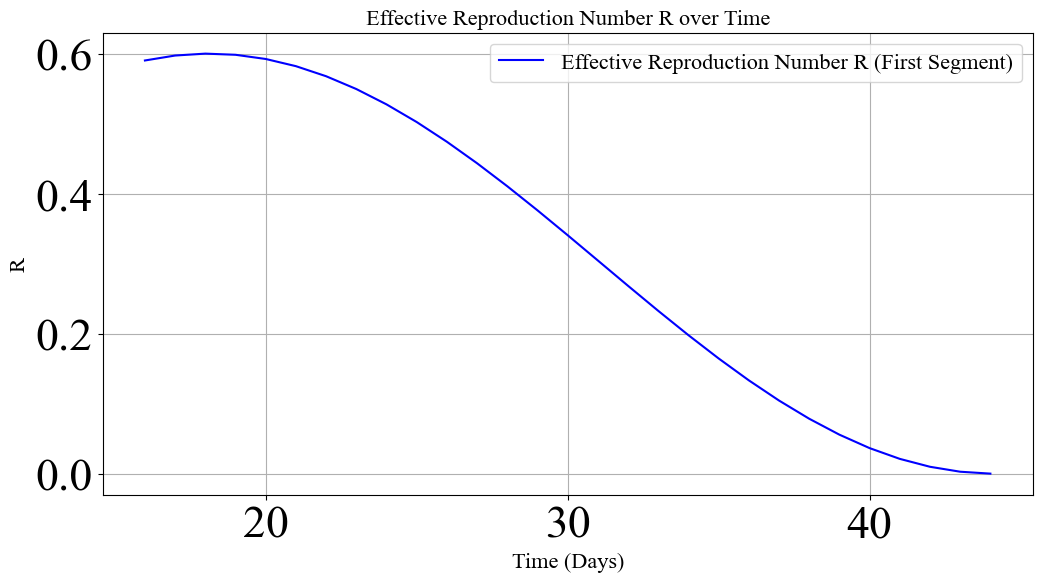

In [264]:
N1 = 2160700


# 定义有效再生数 R 的计算函数
def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    
    # 将大整数转换为浮点数
    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    
    # 计算各项
    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    
    # 计算 R
    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(16, 45)
# 计算 R 随时间的变化（分段）
R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
# R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

import statistics

# 如果 R_2023 是列表
median_R_1 = statistics.median(R_values_1)
# median_R_2 = statistics.median(R_values_2)
print("R_2019 的中位数:", median_R_1)
# print("R_2020 的中位数:", median_R_2)

# 绘制 R 随时间变化的图
plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
# plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 连接 result_1.best_fit 和 result_2.best_fit
result_2019 = result_1.best_fit

# 提取 I_2023[47:329] 的数据
observed_cases_2019 = I_2019[15:44].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2019# 这里是您给出的数据

# 假设模型的预测数据是：
y_pred = result_2019  

# 计算MSE，均方误差
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# 计算RMSE，均方根误差
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 计算R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# 计算MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# 计算MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')

# 2) Pearson 相关及其 p 值
r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 0.6256187064321819
RMSE: 0.79096062255474
R-squared: 0.18045898425316953
MAE: 0.6059419937326137
MAPE: inf%


C:\Users\Irene\AppData\Local\Temp\ipykernel_39640\128889750.py:31: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


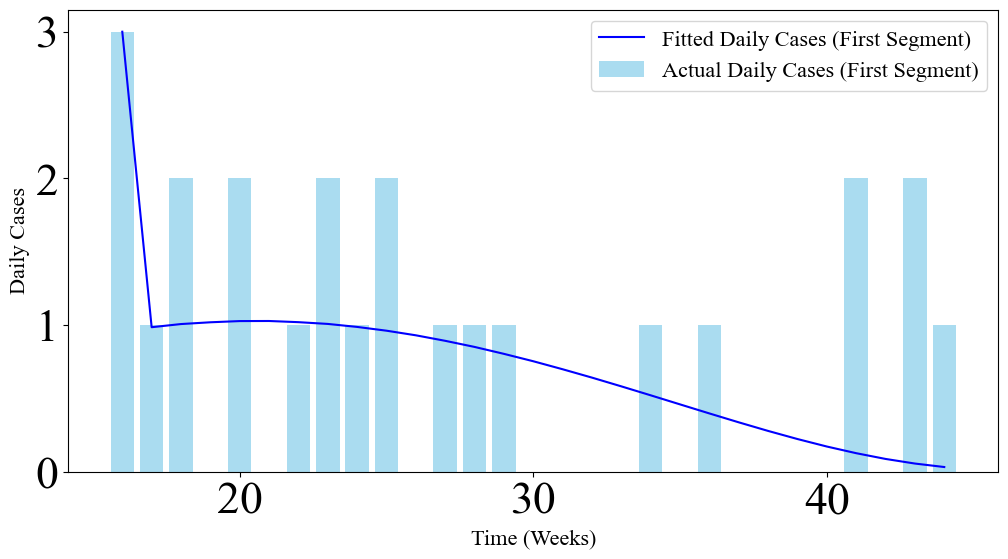

皮尔森相关系数：0.47059047370559964
p值：0.009985369776458792


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(16, 45), observed_cases_2019, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(16, 45), result_2019, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)
plt.savefig('../../outcome/Figure/Fit/Manshan/2019.pdf', format='pdf')
plt.show()

# 计算相关系数
from scipy.stats import pearsonr

# 计算皮尔森相关系数和p值
corr, p_value = pearsonr(observed_cases_2019, result_2019)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

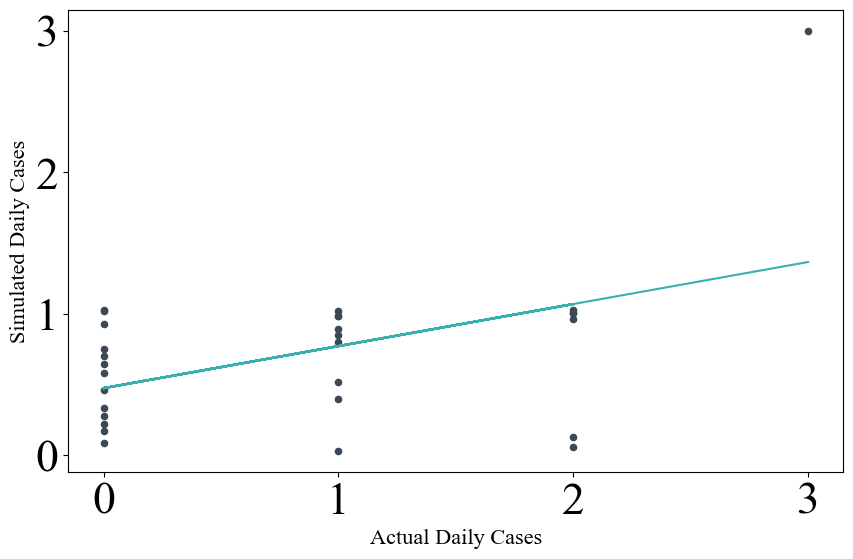

R²：0.2214553939424605


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  # 导入 MaxNLocator

# 确保I_obs和predicted_cases是numpy数组
I_obs = np.array(observed_cases_2019)
predicted_cases = np.array(result_2019)

# 创建线性回归模型
model = LinearRegression()

# 训练模型，需要将I_obs转换为二维数组
model.fit(I_obs.reshape(-1, 1), predicted_cases)

# 预测
y_pred = model.predict(I_obs.reshape(-1, 1))

# 计算R2值
r2 = r2_score(predicted_cases, y_pred)

# 绘制散点图和回归线
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
plt.xlabel('Actual Daily Cases')
plt.ylabel('Simulated Daily Cases')
# plt.legend()
# 设置 y 轴刻度为整数
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../outcome/Figure/Goodness of fit/Manshan/2019.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

Rt_11 的中位数为: 0.34080091079228897
R_2023 的平均数为: 0.32299611165404823


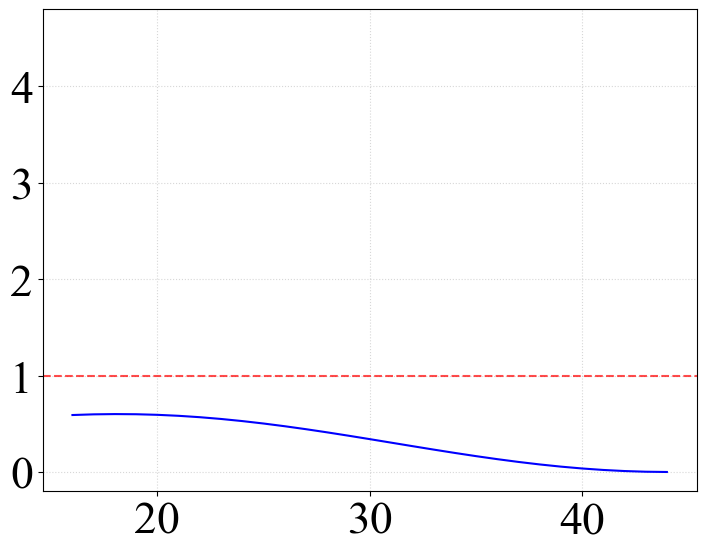

In [268]:
R_2019 = R_values_1
pd.DataFrame(R_2019).to_excel('../../结果图/拟合结果2/R_2019.xlsx', index=False)

import statistics
# 计算Rt_11_values的中位数
median_Rt_11 = statistics.median(R_2019)
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2019)
print(f"R_2023 的平均数为: {average_R}")
# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 
# 创建图表
plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')
# 坐标轴设置
plt.ylim(-0.2, 4.8)
plt.yticks(np.arange(0, 4.1, 1))  # 显式设置y轴刻度，步长为1（确保1可见）
plt.grid(True, linestyle=':', alpha=0.5)
# 保存和显示
plt.tight_layout()
plt.plot(np.arange(16, 45), R_2019, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
# plt.legend()
# plt.ylim(-0.2, 4.2)
plt.savefig('../../结果图/拟合结果2/R_2019.pdf', format='pdf')
plt.show()